In [1]:
# uniform

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.7777777777777778, Loss: 0.7287665473090278
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.6852706626609519
Checkpoint 300, Accuracy: 0.8209876543209876, Loss: 0.6833888866283275
Checkpoint 400, Accuracy: 0.8271604938271605, Loss: 0.6812886132134331
Checkpoint 500, Accuracy: 0.8271604938271605, Loss: 0.6790658456307871


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.91899896]
 [0.03972479]
 [0.04127621]]
[1. 0. 0.] <-> [[0.9380016 ]
 [0.03073942]
 [0.03125892]]
[1. 0. 0.] <-> [[0.92041975]
 [0.03894906]
 [0.04063114]]
[1. 0. 0.] <-> [[0.4268671 ]
 [0.3675024 ]
 [0.20563053]]
[0. 1. 0.] <-> [[0.44802922]
 [0.35767543]
 [0.19429539]]
[1. 0. 0.] <-> [[0.9377374 ]
 [0.03085142]
 [0.03141113]]
[0. 0. 1.] <-> [[0.6658897 ]
 [0.20766075]
 [0.12644951]]
[1. 0. 0.] <-> [[0.9324251 ]
 [0.03301474]
 [0.03456013]]
[0. 0. 1.] <-> [[0.02202828]
 [0.3449457 ]
 [0.63302606]]
[1. 0. 0.] <-> [[0.93819755]
 [0.03065593]
 [0.03114656]]
[1. 0. 0.] <-> [[0.9384711 ]
 [0.03053901]
 [0.0309899 ]]
[1. 0. 0.] <-> [[0.29693604]
 [0.4181155 ]
 [0.28494853]]
[1. 0. 0.] <-> [[0.4429931 ]
 [0.36007175]
 [0.19693509]]
[1. 0. 0.] <-> [[0.93466496]
 [0.0321051 ]
 [0.03322989]]
[0. 1. 0.] <-> [[0.10714614]
 [0.44030187]
 [0.45255205]]
[1. 0. 0.] <-> [[0.93739736]
 [0.03099424]
 [0.03160837]]
[1. 0. 0.] <-> [[0.93827957]
 [0.03062086]
 [0.03109955]]
[1. 0. 0.] <->

In [12]:
# Testing Performance

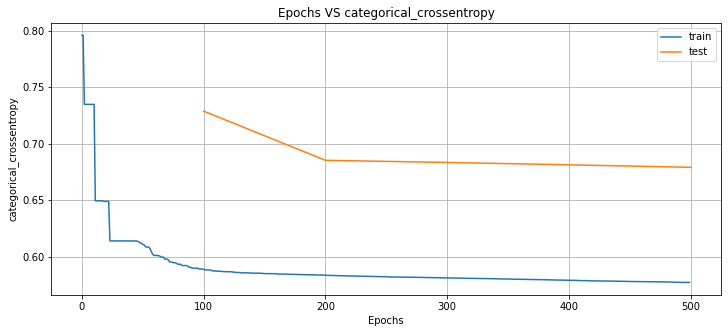

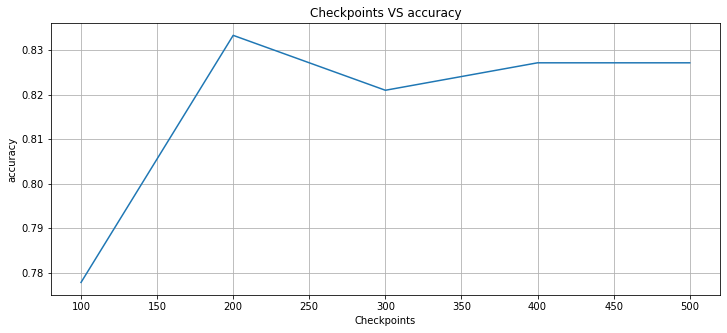

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.7777777777777778, 'mean_square_error': 2.929110509821916, 'categorical_crossentropy': 0.7287665473090278, 'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1': 0.6666666666666666, 'essential_metrics': {0: {'tp_hit': 59, 'fp_hit': 13, 'tn_hit': 19, 'fn_hit': 17}, 1: {'tp_hit': 6, 'fp_hit': 20, 'tn_hit': 71, 'fn_hit': 11}, 2: {'tp_hit': 7, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 8}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.9277018925455076, 'categorical_crossentropy': 0.6852706626609519, 'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'essential_metrics': {0: {'tp_hit': 70, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 6}, 1: {'tp_hit': 4, 'fp_hit': 9, 'tn_hit': 82, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 8}}, 'checkpoint': 200} 


{'accuracy': 0.8209876543209876, 'mean_square_error': 2.911905964159325, 'categorical_crossentropy': 0.6833888866283275, 'precision': 0.7314814814814815, 'recall': 0.731481481

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.3881601]
 [ 1.1415312]
 [-2.497213 ]
 [-2.6569912]
 [-2.9341712]]
 bias: [-0.8462659]

Neuron 1: weights:
[[-2.6118495 ]
 [-0.87235373]
 [ 2.1601167 ]
 [-1.8529046 ]
 [ 1.9039545 ]]
 bias: [2.9314628]

Neuron 2: weights:
[[ 1.1184971]
 [ 2.6612072]
 [ 1.8953313]
 [-2.3269272]
 [-3.       ]]
 bias: [-0.01336488]

Neuron 3: weights:
[[ 2.0885735 ]
 [-2.6820443 ]
 [ 0.04704977]
 [ 0.30586827]
 [-0.82376254]]
 bias: [-1.9867139]

$
Layer 2
Neuron 0: weights:
[[ 2.5461051]
 [ 1.4034051]
 [-1.4801598]
 [ 1.6964303]]
 bias: [1.2059728]

Neuron 1: weights:
[[-0.14677134]
 [-0.9509884 ]
 [ 0.9378688 ]
 [ 2.3147676 ]]
 bias: [1.6954486]

Neuron 2: weights:
[[ 0.7033978]
 [-1.7327069]
 [ 2.3803394]
 [ 2.7100606]]
 bias: [0.95282733]

$

